In [3]:
%config IPCompleter.use_jedi=False

In [44]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt

### 1. Download, extract and load CIFAR10 image dataset using torchvision

In [135]:
cifar_train_main = datasets.CIFAR10(root="data", download=True, train=True, transform=ToTensor())

Files already downloaded and verified


In [136]:
cifar_train, cifar_val = torch.utils.data.random_split(cifar_train_main, [40000, 10000])


In [137]:
cifar_test = datasets.CIFAR10(root="data", download=True, train=False, transform=ToTensor())

Files already downloaded and verified


In [115]:
cifar_train

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [145]:
batch_size=64

In [146]:
train_loader = DataLoader(cifar_train, batch_size=batch_size)

In [147]:
val_loader = DataLoader(cifar_val, batch_size=batch_size)

In [148]:
test_loader = DataLoader(cifar_test, batch_size=batch_size)

### Check the device

In [21]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### 2. Show random batches of images in a grid using torchvision.utils.make_grid

In [133]:
from torchvision.utils import make_grid

In [141]:
class_names = cifar_train_main.classes
class_names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [142]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (30, 30),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

In [143]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(30, 40))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

In [40]:
def show_example(img, label):
    print('Label: ', cifar_train.classes[label], "("+str(label)+")")
    #width->height->channel instead of channel->height->width
    plt.imshow(img.permute(1, 2, 0))

Label:  frog (6)


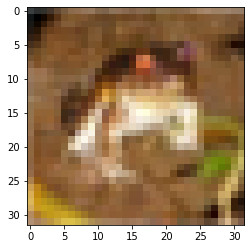

In [60]:
show_example(*cifar_train[0])

### 3. Create a convolutional neural network using with nn.Conv2d and nn.MaxPool2d layers

### Convolutional Neural Networks
<img src="https://miro.medium.com/max/1070/1*Zx-ZMLKab7VOCQTxdZ1OAw.gif" style="max-width:400px;">

In [124]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [149]:
class Cifar10CnnModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4

            nn.Flatten(), 
            nn.Linear(256*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10))
        
    def forward(self, xb):
        return self.network(xb)

In [150]:
net = Cifar10CnnModel()
net
model = net
model

Cifar10CnnModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten()
    (16): Linear(in_features=4096, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in_features=1024, out_features

In [151]:
for images, labels in train_loader:
    print('images.shape:', images.shape)
    out = model(images)
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break

images.shape: torch.Size([64, 3, 32, 32])
out.shape: torch.Size([64, 10])
out[0]: tensor([ 0.0096, -0.0365,  0.0364,  0.0009,  0.0143, -0.0201, -0.0262,  0.0097,
         0.0104, -0.0116], grad_fn=<SelectBackward>)


In [152]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [154]:
device = get_default_device()
device

device(type='cuda')

In [177]:
train_dl = DeviceDataLoader(train_loader, device)
val_dl = DeviceDataLoader(val_loader, device)
test_dl = DeviceDataLoader(test_loader, device)
to_device(model, device);

### Define the Loss function and the optimizer

In [158]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [159]:
model = to_device(Cifar10CnnModel(), device)

In [160]:
evaluate(model, val_dl)

{'val_loss': 2.302886486053467, 'val_acc': 0.09962181746959686}

In [ ]:
evaluate(model, val_dl)

In [187]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.001

In [188]:
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 0.4050, val_loss: 1.2067, val_acc: 0.6893
Epoch [1], train_loss: 0.3068, val_loss: 1.4055, val_acc: 0.6863
Epoch [2], train_loss: 0.2585, val_loss: 1.5231, val_acc: 0.6839
Epoch [3], train_loss: 0.2203, val_loss: 1.5872, val_acc: 0.6913
Epoch [4], train_loss: 0.1998, val_loss: 1.6599, val_acc: 0.6884
Epoch [5], train_loss: 0.1596, val_loss: 1.7954, val_acc: 0.6743
Epoch [6], train_loss: 0.1375, val_loss: 1.9018, val_acc: 0.6748
Epoch [7], train_loss: 0.1310, val_loss: 1.7969, val_acc: 0.6895
Epoch [8], train_loss: 0.1231, val_loss: 1.8593, val_acc: 0.6923
Epoch [9], train_loss: 0.1123, val_loss: 2.0013, val_acc: 0.6858


In [189]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

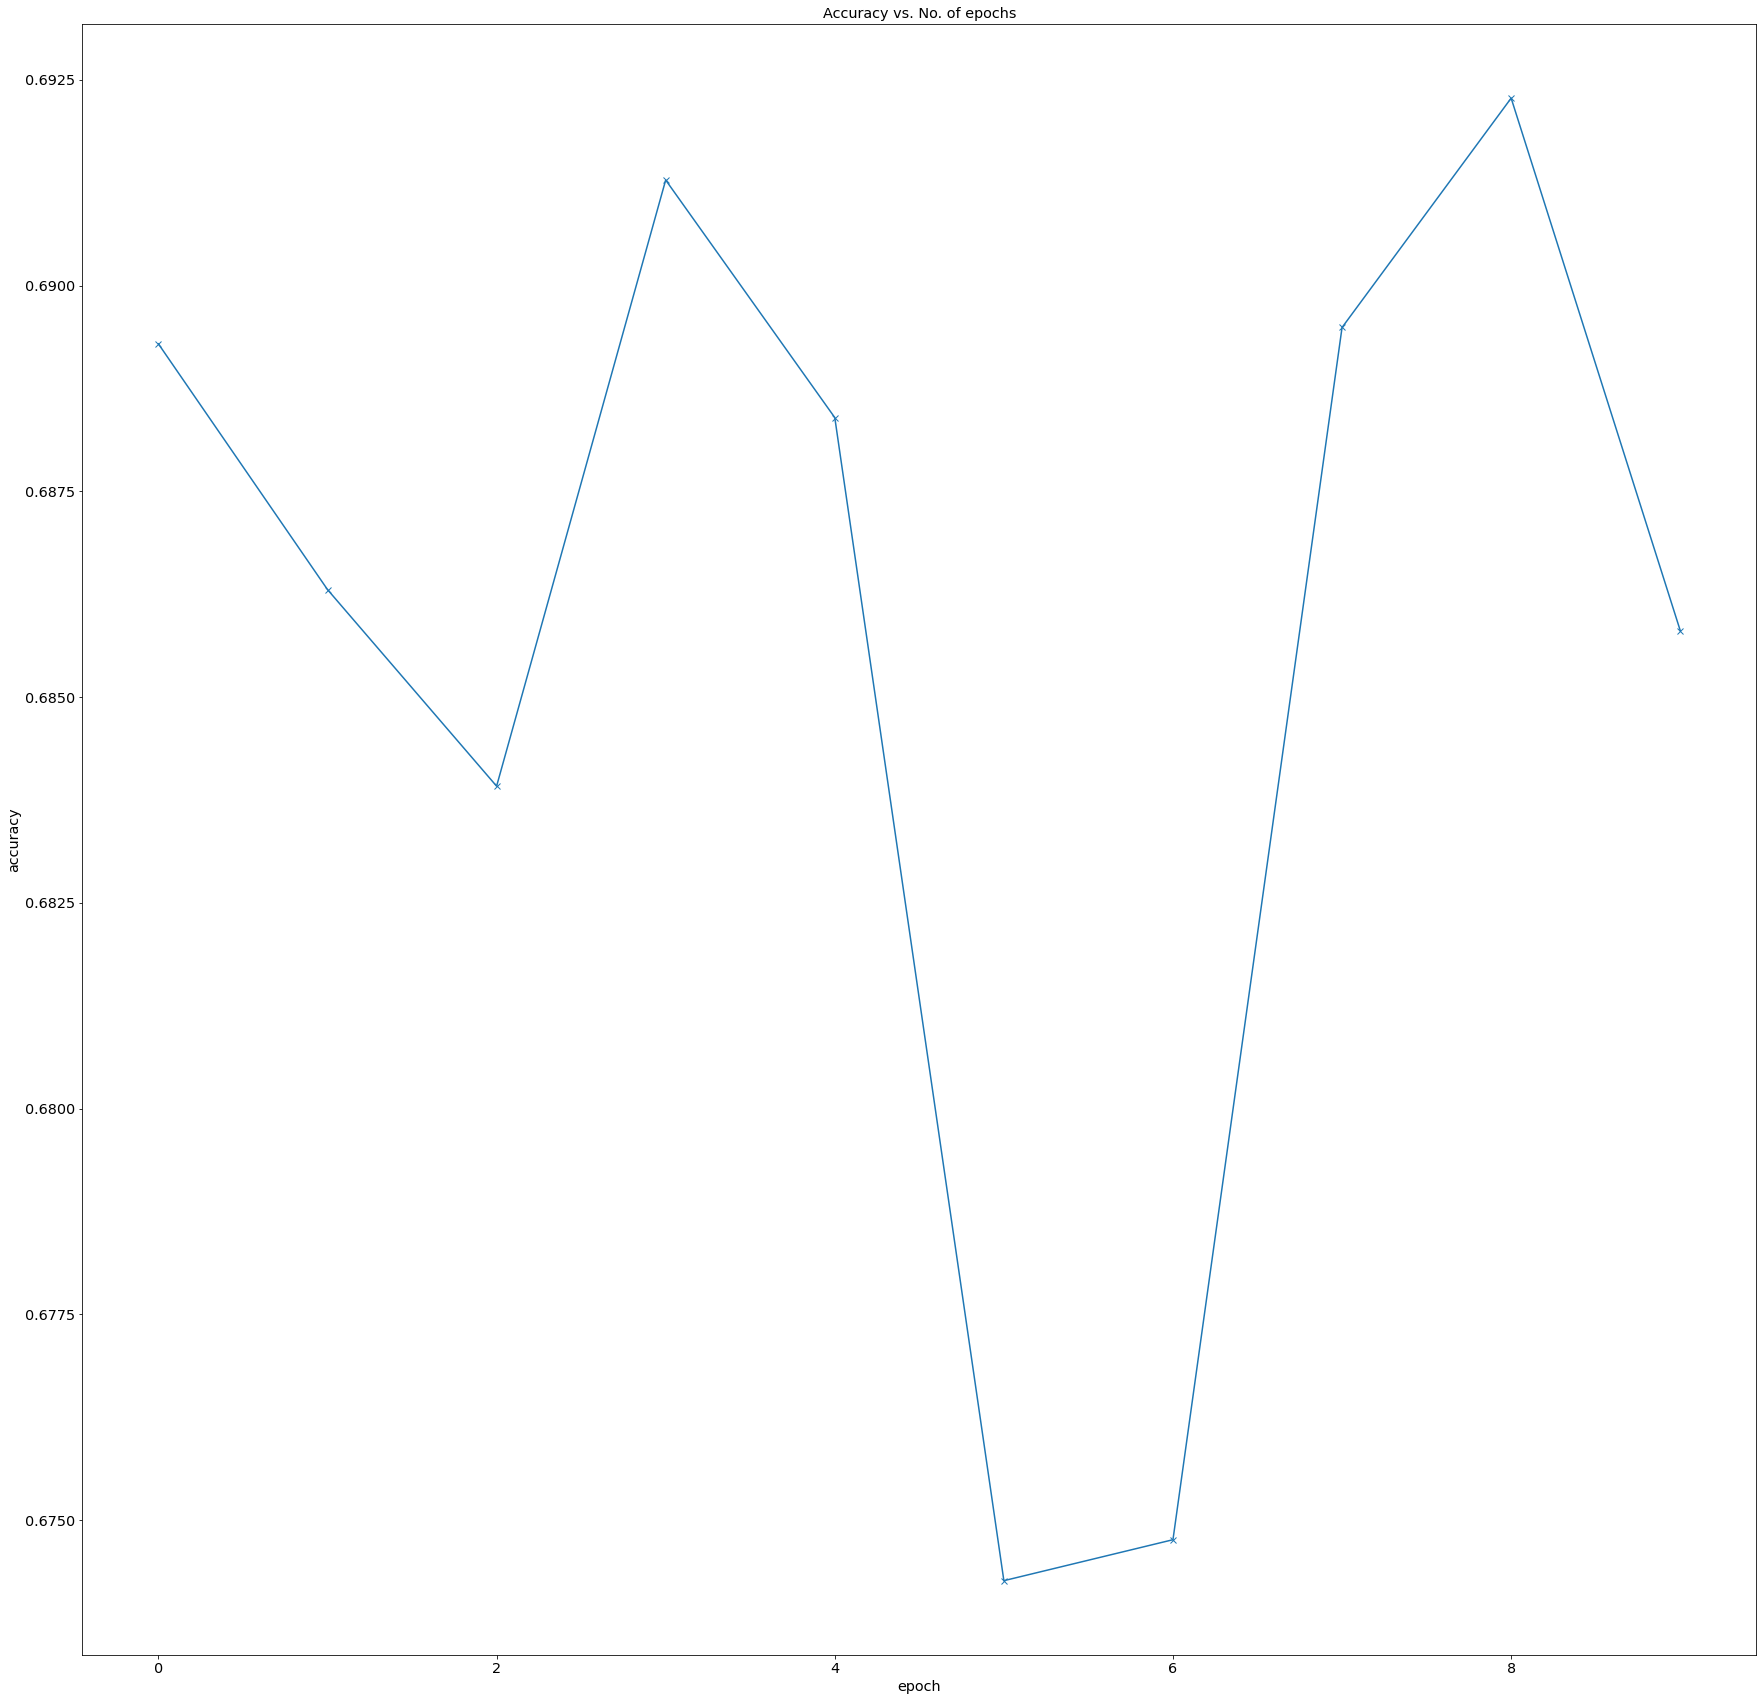

In [190]:
plot_accuracies(history)

In [191]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

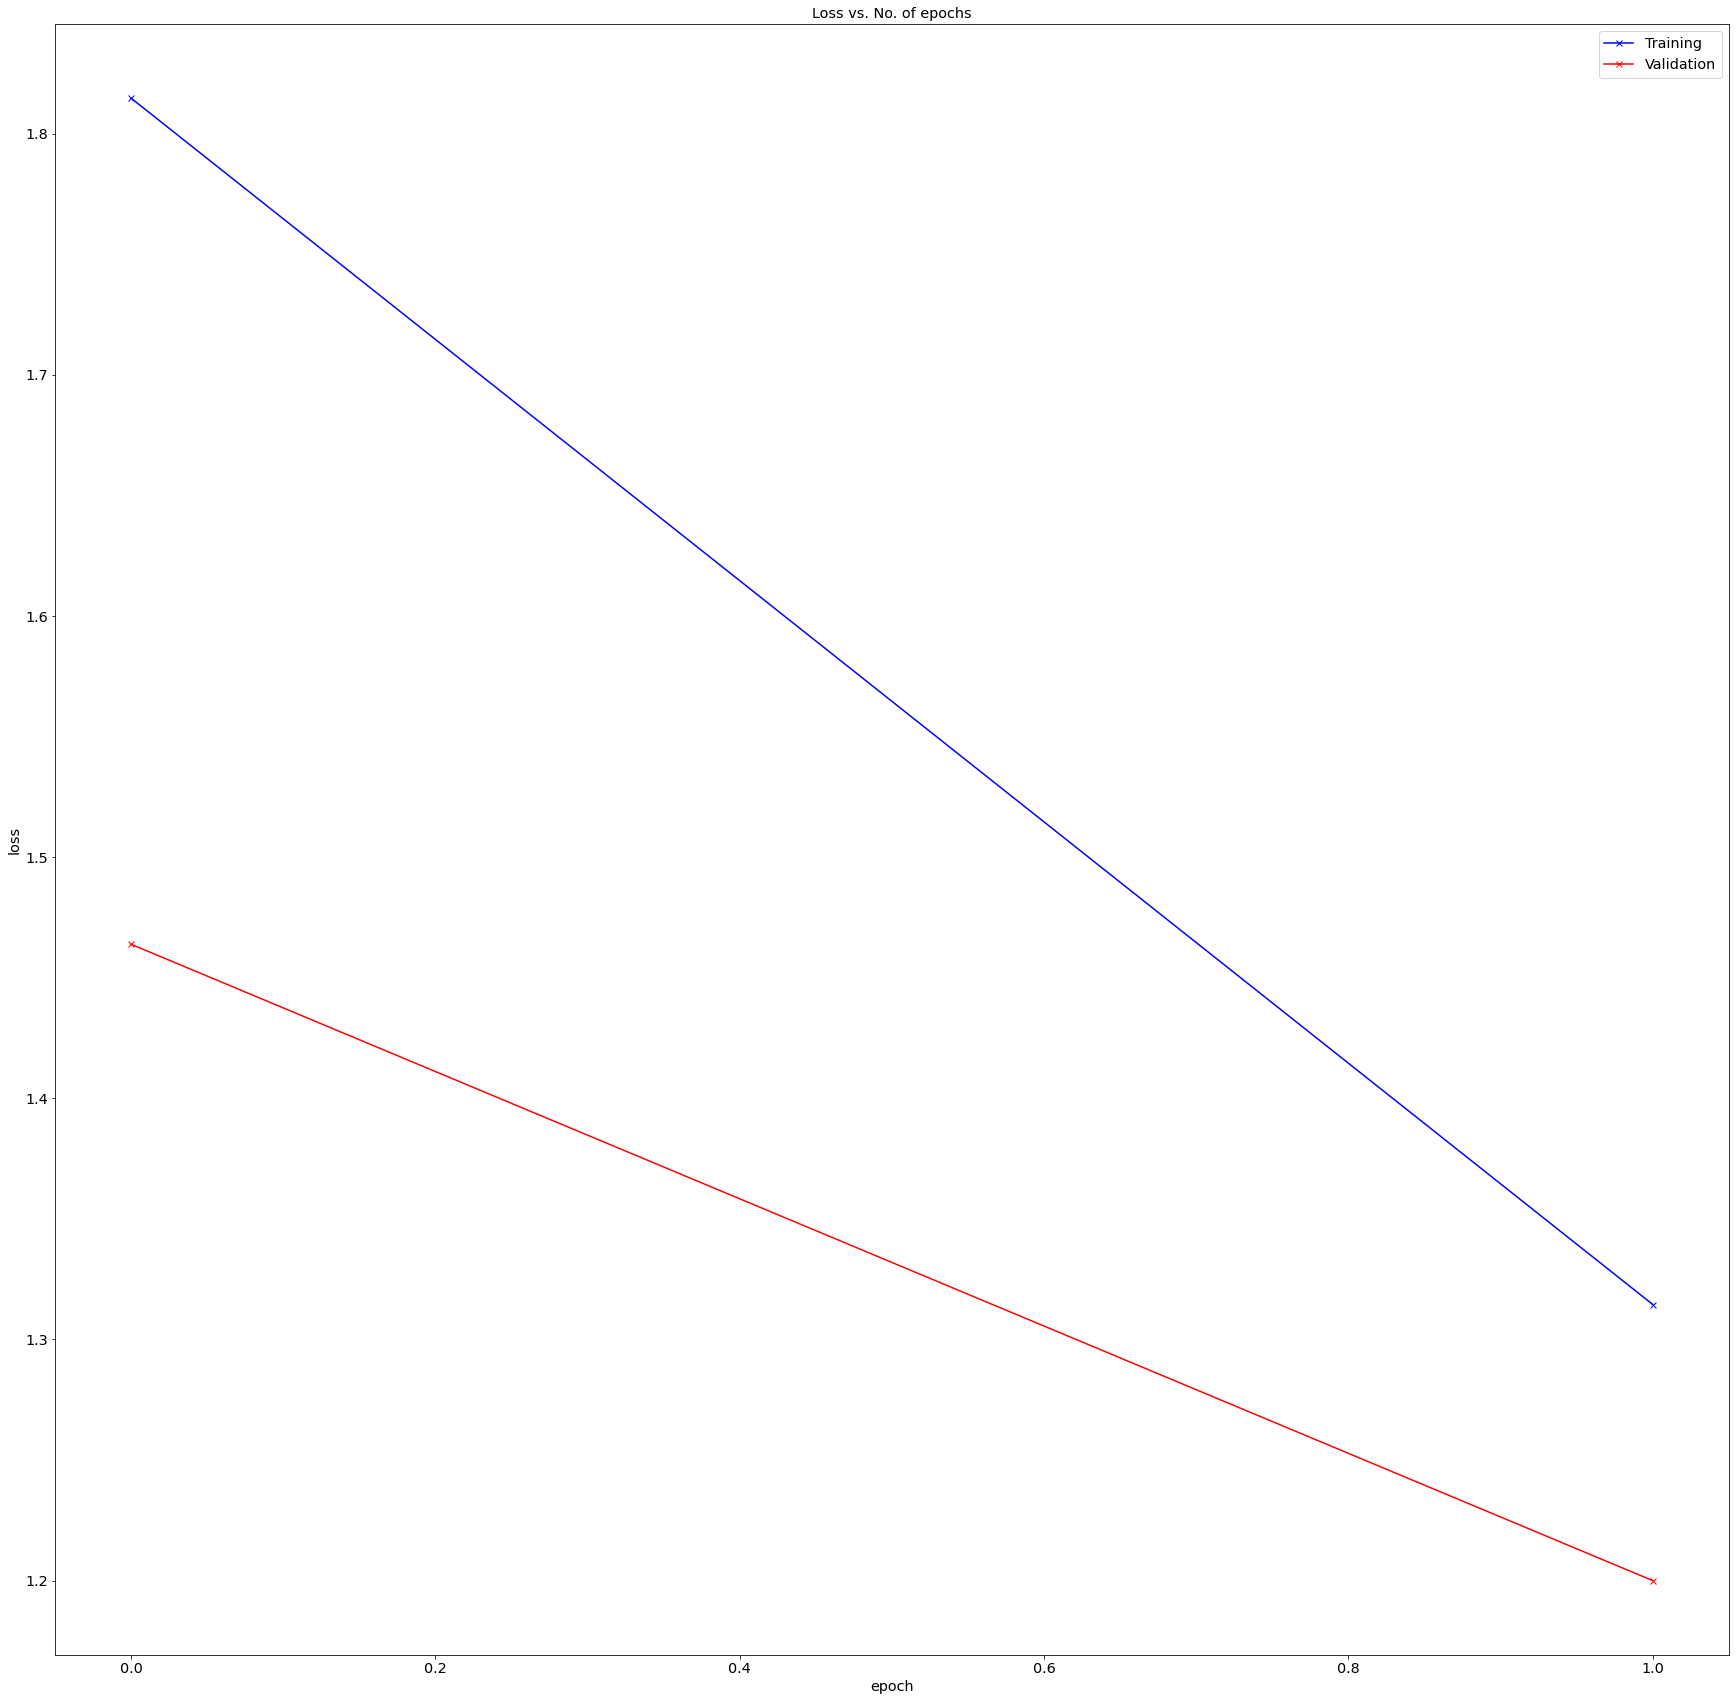

In [166]:
plot_losses(history)

GroundTruth:    cat  ship  ship airplane


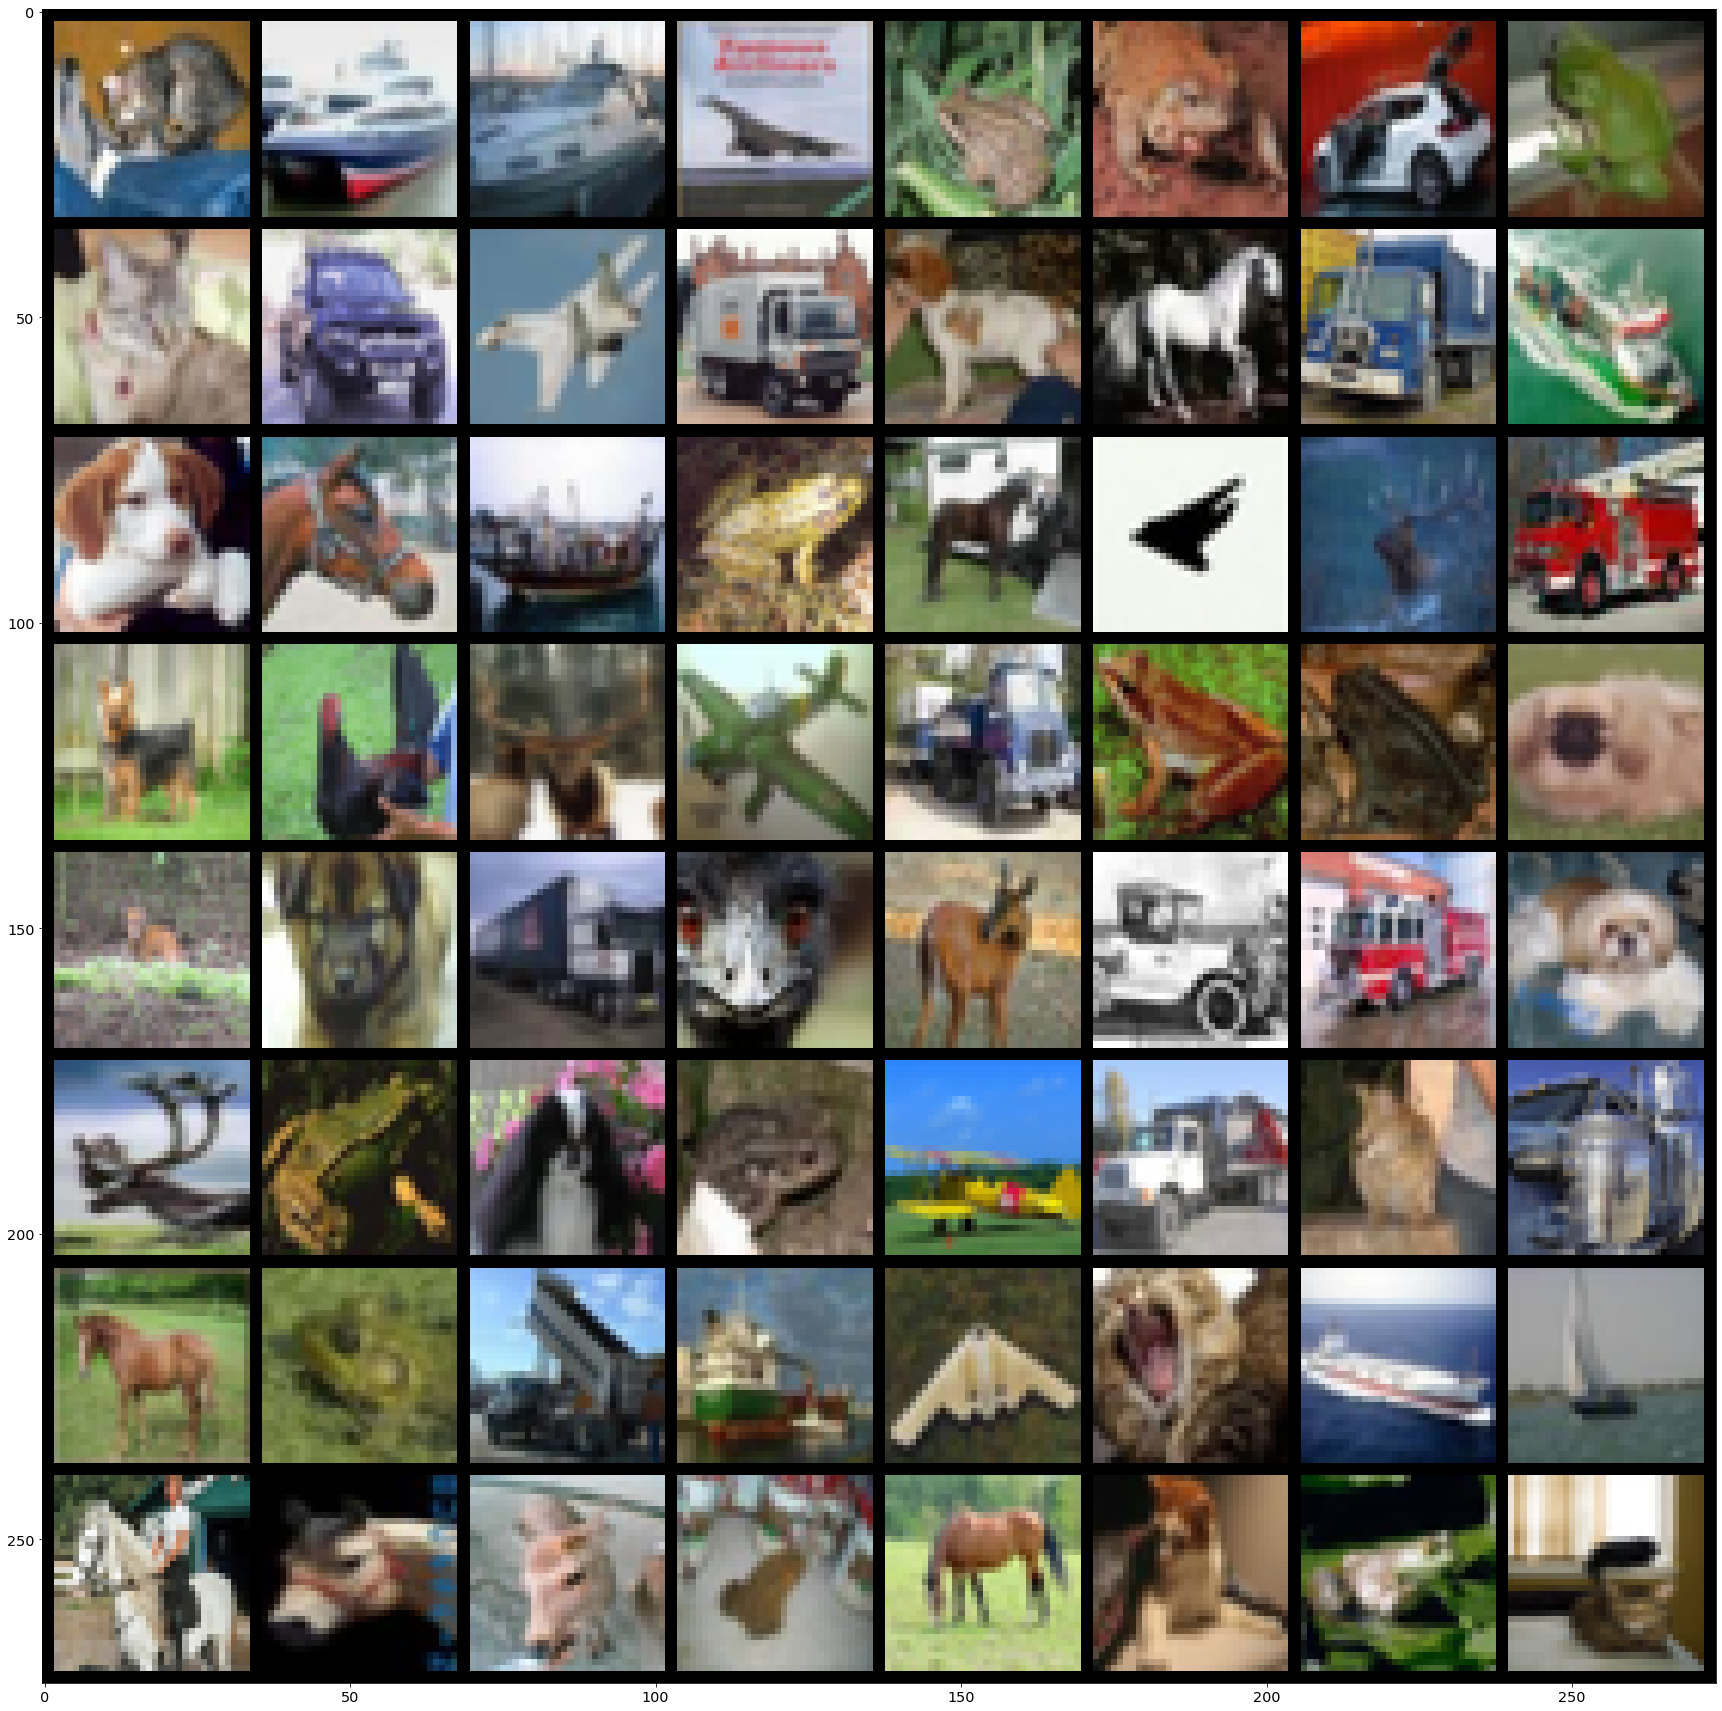

In [192]:
dataiter = iter(test_loader)
images, labels = dataiter.next()
plt.figure(figsize=(30,40))
# print images
plt.imshow(torchvision.utils.make_grid(images).permute(1,2,0))
print('GroundTruth: ', ' '.join('%5s' %cifar_train_main.classes[labels[j]] for j in range(4)))

In [193]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
model.eval()
with torch.no_grad():
    for data in test_dl:
        images, labels = data
        outputs = model(images)
        vals, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(10):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        cifar_test.classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of airplane : 73 %
Accuracy of automobile : 81 %
Accuracy of  bird : 43 %
Accuracy of   cat : 39 %
Accuracy of  deer : 67 %
Accuracy of   dog : 66 %
Accuracy of  frog : 79 %
Accuracy of horse : 77 %
Accuracy of  ship : 76 %
Accuracy of truck : 75 %


### 6. Generate predictions on single images from the test set


In [209]:
vals, predicted = torch.max(model2(next(iter(test_dl))[0][:1]),1)

In [210]:
predicted

tensor([5], device='cuda:0')

In [207]:
outputs = model2(next(iter(test_dl))[0])

In [208]:
torch.max(outputs, 1)

torch.return_types.max(
values=tensor([ 6.7581,  8.2454, 10.5099, 12.7164,  8.3594,  9.6022,  4.6855,  6.7318,
         7.9744,  5.8280,  4.2959, 33.4682,  5.1305, 14.4084, 32.2577,  2.6427,
        16.0687,  1.0812, 25.1628,  9.9080, 10.6584, 19.4715,  6.6458, 33.7505,
        11.3651,  2.7851, 14.3328,  0.3082, 13.1504, 13.2673, 11.1234,  9.9965,
         9.2200, 12.4290, 26.5676,  8.5773, 14.9042, 13.5563, 13.1612,  8.8580,
         7.2857, 15.9040, 11.3612, 18.8003, 10.3971, 22.5425,  5.3155,  1.9539,
        32.1733, 12.5003, 23.1482,  1.9854,  4.0844,  2.9216, 25.7184, 15.9947,
         8.3002,  4.8416,  7.1972,  3.2635, 29.8168,  9.6602,  9.7845, 11.5662],
       device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor([5, 1, 8, 0, 6, 6, 1, 6, 3, 9, 5, 9, 4, 7, 9, 4, 5, 9, 8, 6, 7, 2, 4, 9,
        4, 2, 4, 6, 9, 6, 6, 5, 4, 5, 9, 1, 4, 9, 9, 5, 4, 6, 7, 6, 0, 9, 3, 3,
        7, 6, 9, 0, 2, 5, 8, 8, 3, 6, 6, 4, 7, 5, 4, 3], device='cuda:0'))

### 7. Save and load model for further purposes

https://cs.stanford.edu/people/karpathy/convnetjs/demo/cifar10.html

In [205]:
torch.save(model,"model.torch")

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Cifar10CnnModel. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [206]:
model2 = torch.load("model.torch")